In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# Build the dataset for exploratory data analysis and visualization

In [2]:
df = pd.read_csv('ks-projects-201801.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


## Construct a new variable "number of words in the KS project name"

In [4]:
df['name'].head()

0                      The Songs of Adelaide & Abullah
1        Greeting From Earth: ZGAC Arts Capsule For ET
2                                       Where is Hank?
3    ToshiCapital Rekordz Needs Help to Complete Album
4    Community Film Project: The Art of Neighborhoo...
Name: name, dtype: object

In [5]:
df['name'] = df['name'].apply(lambda x: str(x))

In [6]:
df['len_name'] = df['name'].apply(lambda x: len(x.split()))

## Construct "deadline year", "deadline month", "launched year", "launched month" and "time of duration" variables

In [7]:
df['deadline_year'] = pd.DatetimeIndex(df['deadline']).year
df['deadline_month'] = pd.DatetimeIndex(df['deadline']).month
df['launched_year'] = pd.DatetimeIndex(df['launched']).year
df['launched_month'] = pd.DatetimeIndex(df['launched']).month

In [8]:
df['deadline']=pd.to_datetime(df['deadline'])

In [9]:
df['launched']=pd.to_datetime(df['launched'])

In [10]:
df['time_of_duration'] = (df['deadline'] - df['launched']).apply(lambda x: x.days)

## Construct a new variable "usd pledged per backer"

In [12]:
def pledged_per_backer(x):
    if x['backers'] == 0:
        return 0
    else:
        return x['usd_pledged_real']/x['backers']

df['usd_pledged_per_backer'] = df.apply(lambda x: pledged_per_backer(x), axis = 1)

In [13]:
df['usd_pledged_per_backer'].unique()

array([  0.        , 161.4       ,  73.33333333, ...,  55.8716129 ,
        63.89346154,  79.88416667])

## Construct a new variable "the percentage of the goal achieved" meaning the extent of goal fulfillment

In [14]:
df['percentage_goal_achieved'] = df['usd_pledged_real'] / df['usd_goal_real']

In [15]:
df['percentage_goal_achieved'].unique()

array([0.        , 0.0807    , 0.00488889, ..., 1.10019846, 1.07500028,
       0.02369231])

In [16]:
(df['usd pledged'] == df['usd_pledged_real']).mean()

0.6935781609407887

## Construct a new dataset "rate of success" of which the columns are launched_year, main category, and success rate

In [17]:
df['launched_year'].unique()

array([2015, 2017, 2013, 2012, 2016, 2014, 2010, 2011, 2009, 1970, 2018])

In [18]:
df['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

In [19]:
years=sorted([2015, 2017, 2013, 2012, 2016, 2014, 2010, 2011, 2009, 2018])
category = ['Publishing', 'Film & Video', 'Music', 'Food', 'Design', 'Crafts',
       'Games', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism']
rate_of_suc=[]
years_final=[]
cat_final=[]
for year in years:
    for cat in category:
        rate_of_suc.append((df[(df['launched_year'] == year)&(df['main_category']==cat)]['state'] == 'successful').mean())
        years_final.append(year)
    cat_final+=category

In [20]:
df_ros=pd.DataFrame(data={"year": years_final, "category":cat_final,"rate_of_success":rate_of_suc})
df_ros.to_csv("rate_of_success.csv")

## Examine the duplicates and missing values

In [21]:
df = df.drop_duplicates()
len(df) #no duplicated rows

378661

In [22]:
df.isnull().any() #usd pledged and usd_pledged_real is confusing. Only use usd_pledged_real here.

ID                          False
name                        False
category                    False
main_category               False
currency                    False
deadline                    False
goal                        False
launched                    False
pledged                     False
state                       False
backers                     False
country                     False
usd pledged                  True
usd_pledged_real            False
usd_goal_real               False
len_name                    False
deadline_year               False
deadline_month              False
launched_year               False
launched_month              False
time_of_duration            False
usd_pledged_per_backer      False
percentage_goal_achieved    False
dtype: bool

## Save as a new dataset

In [23]:
#df.to_csv('data.csv')

# Statistical Analysis

In [25]:
!pip install plotly

    100% |████████████████████████████████| 37.8MB 614kB/s ta 0:00:0111    66% |█████████████████████▎          | 25.2MB 26.5MB/s eta 0:00:01
  Running setup.py bdist_wheel for retrying ... done
  Stored in directory: /Users/yuhuansu/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [30]:
import numpy as np
from scipy import stats
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import plotly
plotly.tools.set_credentials_file(username='syhvicky', api_key='aDLXWvbgYfLjbiFxf8Nv')

## Two sample independent t-test
Reference: 

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ttest_ind.html

https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/

In [44]:
mean1=[]
mean2=[]
for i in range(100):
    mean1.append(df[df['state'] == 'successful']['usd_pledged_real'].sample(1000).mean())
    mean2.append(df[df['state'] == 'failed']['usd_pledged_real'].sample(1000).mean())
stat, p = stats.ttest_ind(mean1, mean2)
print('t=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Not reject the null hypothesis')
else:
    print('Reject the null hypothesis')

t=44.324, p=0.000
Reject the null hypothesis


In [45]:
matrix = [['', 'Test Statistic', 'p-value'], ['Sample Data', stat, p]]

table = FF.create_table(matrix, index=True)
py.iplot(table, filename='table_1')

/anaconda3/lib/python3.6/site-packages/plotly/tools.py:1545: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



In [47]:
mean1=[]
mean2=[]
for i in range(100):
    mean1.append(df[df['state'] == 'successful']['time_of_duration'].sample(1000).mean())
    mean2.append(df[df['state'] == 'failed']['time_of_duration'].sample(1000).mean())
stat, p = stats.ttest_ind(mean1, mean2)
print('t=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Not reject the null hypothesis')
else:
    print('Reject the null hypothesis')

t=-55.084, p=0.000
Reject the null hypothesis


In [48]:
matrix = [['', 'Test Statistic', 'p-value'], ['Sample Data', stat, p]]

table = FF.create_table(matrix, index=True)
py.iplot(table, filename='table_2')

/anaconda3/lib/python3.6/site-packages/plotly/tools.py:1545: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



In [49]:
mean1=[]
mean2=[]
for i in range(100):
    mean1.append(df[df['state'] == 'successful']['usd_goal_real'].sample(1000).mean())
    mean2.append(df[df['state'] == 'failed']['usd_goal_real'].sample(1000).mean())
stat, p = stats.ttest_ind(mean1, mean2)
print('t=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Not reject the null hypothesis')
else:
    print('Reject the null hypothesis')

t=-13.180, p=0.000
Reject the null hypothesis


In [50]:
matrix = [['', 'Test Statistic', 'p-value'], ['Sample Data', stat, p]]

table = FF.create_table(matrix, index=True)
py.iplot(table, filename='table_3')

/anaconda3/lib/python3.6/site-packages/plotly/tools.py:1545: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



In [51]:
mean1=[]
mean2=[]
for i in range(100):
    mean1.append(df[df['state'] == 'successful']['usd_pledged_per_backer'].sample(1000).mean())
    mean2.append(df[df['state'] == 'failed']['usd_pledged_per_backer'].sample(1000).mean())
stat, p = stats.ttest_ind(mean1, mean2)
print('t=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Not reject the null hypothesis')
else:
    print('Reject the null hypothesis')

t=80.557, p=0.000
Reject the null hypothesis


In [52]:
matrix = [['', 'Test Statistic', 'p-value'], ['Sample Data', stat, p]]

table = FF.create_table(matrix, index=True)
py.iplot(table, filename='table_4')

/anaconda3/lib/python3.6/site-packages/plotly/tools.py:1545: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



In [53]:
mean1=[]
mean2=[]
for i in range(100):
    mean1.append(df[df['state'] == 'successful']['len_name'].sample(1000).mean())
    mean2.append(df[df['state'] == 'failed']['len_name'].sample(1000).mean())
stat, p = stats.ttest_ind(mean1, mean2)
print('t=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Not reject the null hypothesis')
else:
    print('Reject the null hypothesis')

t=47.974, p=0.000
Reject the null hypothesis


In [54]:
matrix = [['', 'Test Statistic', 'p-value'], ['Sample Data', stat, p]]

table = FF.create_table(matrix, index=True)
py.iplot(table, filename='table_5')

/anaconda3/lib/python3.6/site-packages/plotly/tools.py:1545: UserWarning:

plotly.tools.FigureFactory.create_table is deprecated. Use plotly.figure_factory.create_table



## Chi-square test
Reference:
https://codingdisciple.com/chi-squared-python.html


In [151]:
data_suc = df[df['state'] == 'successful'].copy()
data_fail = df[df['state'] == 'failed'].copy()
data = pd.concat([data_suc, data_fail])

Category - State(successful or failed)

In [134]:
df_1 = pd.DataFrame(data[['state', 'category']])
df_1.head()

,state,category
5,successful,Restaurants
6,successful,Food
11,successful,Indie Rock
14,successful,Tabletop Games
18,successful,Music


In [135]:
df_1['state'].value_counts().head()

failed        197719
successful    133956
Name: state, dtype: int64

In [136]:
df_1['category'].value_counts().head()

Product Design    18680
Documentary       14523
Music             12633
Tabletop Games    11744
Shorts            11394
Name: category, dtype: int64

In [137]:
contingency_table = pd.crosstab(
    df_1['state'],
    df_1['category'],
    margins = True
)
contingency_table

category,3D Printing,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,Apps,Architecture,...,Weaving,Web,Webcomics,Webseries,Woodworking,Workshops,World Music,Young Adult,Zines,All
state,,,,,,,,,,,,,,,,,,,,,
failed,326,589,1667,514,166,1531,216,4752,4909,463,...,55,3866,241,3450,766,98,1018,538,176,197719
successful,242,188,1073,107,63,682,521,1414,378,179,...,27,443,358,1698,292,50,922,172,179,133956
All,568,777,2740,621,229,2213,737,6166,5287,642,...,82,4309,599,5148,1058,148,1940,710,355,331675


In [138]:
d = np.array([contingency_table.iloc[0].values,
                  contingency_table.iloc[1].values])

In [139]:
chistats=stats.chi2_contingency(d)[0:3]
chistats

(31580.991471277444, 0.0, 159)

In [140]:
critical_value = stats.chi2.ppf(q=1-0.05, df=chistats[2])
if chistats[0] <= critical_value:
    # observed value is not in critical area therefore we accept null hypothesis
    print('Null hypothesis cannot be rejected')
else:
    # observed value is in critical area therefore we reject null hypothesis
    print('Reject the null hypotheis')

Reject the null hypotheis


Main category - State(successful or failed)

In [141]:
df_2 = pd.DataFrame(data[['state', 'main_category']])
df_2['state'].value_counts().head()
df_2['main_category'].value_counts().head()
contingency_table = pd.crosstab(
    df_2['state'],
    df_2['main_category'],
    margins = True
)
d = np.array([contingency_table.iloc[0].values,
                  contingency_table.iloc[1].values])
chistats=stats.chi2_contingency(d)[0:3]
chistats

(15455.435709922262, 0.0, 15)

In [152]:
critical_value = stats.chi2.ppf(q=1-0.05, df=chistats[2])
if chistats[0] <= critical_value:
    print('Null hypothesis cannot be rejected')
else:
    print('Reject the null hypotheis')

Reject the null hypotheis


Country (geo) - State

In [143]:
df_3 = pd.DataFrame(data[['state', 'country']])
df_3['state'].value_counts().head()
df_3['country'].value_counts().head()
contingency_table = pd.crosstab(
    df_3['state'],
    df_3['country'],
    margins = True
)
d = np.array([contingency_table.iloc[0].values,
                  contingency_table.iloc[1].values])
chistats=stats.chi2_contingency(d)[0:3]
chistats

(2207.9085420347137, 0.0, 23)

In [144]:
critical_value = stats.chi2.ppf(q=1-0.05, df=chistats[2])
if chistats[0] <= critical_value:
    print('Null hypothesis cannot be rejected')
else:
    print('Reject the null hypotheis')

Reject the null hypotheis


Launch year - state

In [145]:
df_4 = pd.DataFrame(data[['state', 'launched_year']])
df_4['state'].value_counts().head()
df_4['launched_year'].value_counts().head()
contingency_table = pd.crosstab(
    df_4['state'],
    df_4['launched_year'],
    margins = True
)
d = np.array([contingency_table.iloc[0].values,
                  contingency_table.iloc[1].values])
chistats=stats.chi2_contingency(d)[0:3]
chistats

(5314.506361240434, 0.0, 9)

In [146]:
critical_value = stats.chi2.ppf(q=1-0.05, df=chistats[2])
if chistats[0] <= critical_value:
    print('Null hypothesis cannot be rejected')
else:
    print('Reject the null hypotheis')

Reject the null hypotheis


launch month - state

In [147]:
df_5 = pd.DataFrame(data[['state', 'launched_month']])
df_5['state'].value_counts().head()
df_5['launched_month'].value_counts().head()
contingency_table = pd.crosstab(
    df_5['state'],
    df_5['launched_month'],
    margins = True
)
d = np.array([contingency_table.iloc[0].values,
                  contingency_table.iloc[1].values])
chistats=stats.chi2_contingency(d)[0:3]
chistats

(566.888227498843, 1.2377787820061055e-113, 12)

In [148]:
critical_value = stats.chi2.ppf(q=1-0.05, df=chistats[2])
if chistats[0] <= critical_value:
    print('Null hypothesis cannot be rejected')
else:
    print('Reject the null hypotheis')

Reject the null hypotheis


# Logistics regression 

In [23]:
df_for_logistics = df[['len_name', 'category', 'main_category', 'currency', 
                       'state', 'country', 'usd_goal_real',
                       'deadline_year', 'deadline_month', 'launched_year', 'launched_month', 
                       'time_of_duration']].copy()

In [24]:
df_for_logistics.head()

,len_name,category,main_category,currency,state,country,usd_goal_real,deadline_year,deadline_month,launched_year,launched_month,time_of_duration
0,6,Poetry,Publishing,GBP,failed,GB,1533.95,2015,10,2015,8,58
1,8,Narrative Film,Film & Video,USD,failed,US,30000.00,2017,11,2017,9,59
2,3,Narrative Film,Film & Video,USD,failed,US,45000.00,2013,2,2013,1,44
3,7,Music,Music,USD,failed,US,5000.00,2012,4,2012,3,29
4,8,Film & Video,Film & Video,USD,canceled,US,19500.00,2015,8,2015,7,55


In [25]:
df_for_logistics['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.feature_selection import RFE

In [27]:
df_for_logistics['state']=[1  if s == 'successful' else 0 for s in df_for_logistics['state']]

In [28]:
y=df_for_logistics['state']
X=df_for_logistics.drop(['state'],axis=1)
cols=X.columns
encoder=sklearn.preprocessing.LabelEncoder()
#encoding
X['category']=encoder.fit_transform(X['category'])
X['main_category']=encoder.fit_transform(X['main_category'])
X['currency']=encoder.fit_transform(X['currency'])
X['country']=encoder.fit_transform(X['country'])


In [29]:
logistics_data = pd.concat([X,y],axis=1)
logistics_data.head()
logistics_data.to_csv('logistics_data.csv')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(solver="liblinear")
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
pred=logreg.predict(X_test)
accuracy=(pred==y_test).mean()
print(accuracy)

0.6502169913467548


In [32]:
rfe = RFE(logreg,n_features_to_select=1)
rfe = rfe.fit(X, y)
feature_ranking=list(rfe.ranking_)
for f in feature_ranking:
    print(f,X_train.columns[f-1])

1 len_name
7 deadline_year
4 currency
2 category
8 deadline_month
11 time_of_duration
9 launched_year
6 usd_goal_real
10 launched_month
5 country
3 main_category


# Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
clf=RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [39]:
clf.score(X_test,y_test)

0.6595744680851063

In [40]:
importance=list(clf.feature_importances_)
sorted(zip(importance,X_train.columns),key=lambda x: x[0],reverse=True)

[(0.40838420435550804, 'usd_goal_real'),
 (0.18214865690298634, 'time_of_duration'),
 (0.1334179253808806, 'launched_year'),
 (0.12425534266554467, 'deadline_year'),
 (0.05987602581134644, 'len_name'),
 (0.04135270843010945, 'main_category'),
 (0.031963310040549496, 'category'),
 (0.009966043093838589, 'country'),
 (0.00713225749772909, 'currency'),
 (0.0007657130605385153, 'deadline_month'),
 (0.0007378127609684898, 'launched_month')]

In [41]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_test, y_test)
tree.export_graphviz(clf, out_file='tree.dot')

## Construct new datasets including only the name of the successful and failed projects

In [108]:
df_for_text_successful = df[df['state'] == 'successful']['name']
df_for_text_failed = df[df['state'] == 'failed']['name']

In [109]:
df_for_text_successful.to_csv('text_successful.csv')

In [110]:
df_for_text_failed.to_csv('text_failed.csv')

## Plot word cloud

Reference: https://www.datacamp.com/community/tutorials/wordcloud-python

In [87]:
!pip install wordcloud

You are using pip version 9.0.2, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [88]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

In [89]:
df_for_text_successful.columns = ['id', 'name']
df_for_text_successful=df_for_text_successful.reset_index(drop=False)

In [90]:
text = " ".join(name for name in df_for_text_successful.name)
print ("There are {} Kickstarter projects succeeded since 2009.".format(len(text)))

There are 4989075 Kickstarter projects succeeded since 2009.


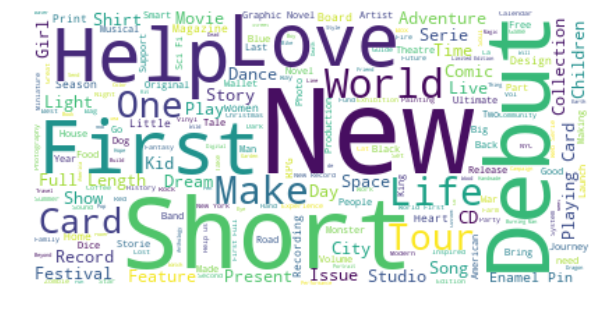

In [91]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Film", "Book", "Album", "Project", "Art", "Game", "Music", "EP", "Documentary", "Video"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [92]:
df_for_text_failed.columns = ['id', 'name']
df_for_text_failed=df_for_text_failed.reset_index(drop=False)

In [93]:
text = " ".join(name for name in df_for_text_failed.name)
print ("There are {} Kickstarter projects failed since 2009.".format(len(text)))

There are 6692534 Kickstarter projects failed since 2009.


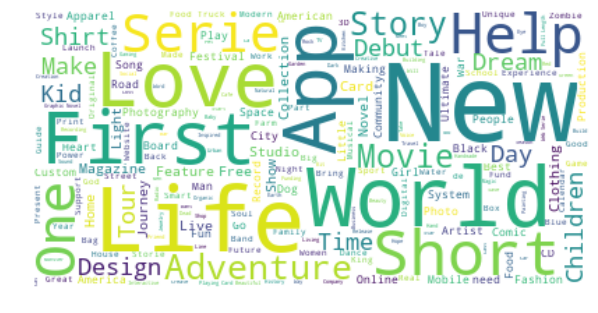

In [94]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Film", "Book", "Album", "Project", "Art", "Game", "Music", "EP", "Documentary", "Video"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()